# MCT4052 Workshop 9a: Autoregressive ANN Raw Audio Generation

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook demonstrate the principle of autoregressive neural network to generate (autoregressively) a raw audio signal (i.e. audio samples). As for the previous notebook, a deep learning frameworks are better suited to build a such kind of neural network, as they allow to customize in detail the internal architecture of the ANN (type of layers, interconnection, etc.). With scikit-learn we are limited to use a feed-forward fully connected ANN (also called "dense" in Tensorflow). In this case we implement the autoregression manually, creating an sample pipeline (delay-line like) line storing previously generated samples.

In the example, we generate sinuosid signal, and we use the oldest 500 samples (this value can be changed using the variable 'recursion_smp') to predict the next one (the ANN is a regressor with 500 inputs an one output). After the ANN is trained, the inference process starts with a sample pipeline line full of noise, that we gradually fill up with ANN generated audio samples.

We also experiment manipulating the contents of the sample pipeline line to generate slightly different sonic outputs.

In [1]:
import numpy as np
import pandas as pd
import librosa
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
#ms.use("seaborn-v0_8")
import IPython.display as Ipd
import os

### 1. Generating a long reference signal that the ANN will learn

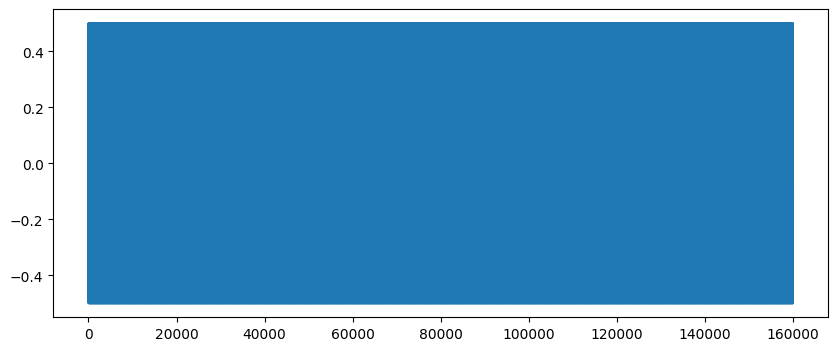

In [2]:
#generating periodic sinusoidal signal
sr = 16000

#frequency
f1 = 440

#amplitude
A = 0.5

t=np.arange(0,10,1/sr)

s = A*np.sin(2*np.pi*f1*t)

plt.figure(figsize=(10, 4))
plt.plot(s)
plt.show()

### 2. Building dataset taking input-sequences and output-target from the reference signal at random points

In [3]:
#setting size of the recursion and size of dataset
regression_size_smp = 500
dataset_size = 9000

#creating empty arrays for input and output
input_data=np.zeros((dataset_size,regression_size_smp))
output_data=np.zeros(dataset_size)

i = 0

#taking slices of recursion_smp samples at random points plus the following sample as target output
while (i < dataset_size):
    index = int(s.size*np.random.random_sample(1))
    if s.size - index < (regression_size_smp+1):
        continue
    input_data[i,:] = s[index:index+regression_size_smp]
    output_data[i] = s[index+regression_size_smp]
    i += 1


In [4]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
input_train, input_test, output_train, output_test = train_test_split(input_data, output_data, test_size=0.2)

### 3. Training the regressor

In [5]:
from sklearn.neural_network import MLPRegressor

##Creating an instance of a MLP regressor
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPRegressor(hidden_layer_sizes=(200,100,50), max_iter=20000, activation='logistic', tol=1e-5, verbose=True)

#train the model
mlp.fit(input_train, output_train)

Iteration 1, loss = 0.04847296
Iteration 2, loss = 0.00361892
Iteration 3, loss = 0.00168153
Iteration 4, loss = 0.00039585
Iteration 5, loss = 0.00016144
Iteration 6, loss = 0.00009116
Iteration 7, loss = 0.00006935
Iteration 8, loss = 0.00006246
Iteration 9, loss = 0.00005989
Iteration 10, loss = 0.00005855
Iteration 11, loss = 0.00005757
Iteration 12, loss = 0.00005674
Iteration 13, loss = 0.00005599
Iteration 14, loss = 0.00005529
Iteration 15, loss = 0.00005461
Iteration 16, loss = 0.00005395
Iteration 17, loss = 0.00005329
Iteration 18, loss = 0.00005264
Training loss did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.


MLPRegressor(activation='logistic', hidden_layer_sizes=(200, 100, 50),
             max_iter=20000, tol=1e-05, verbose=True)

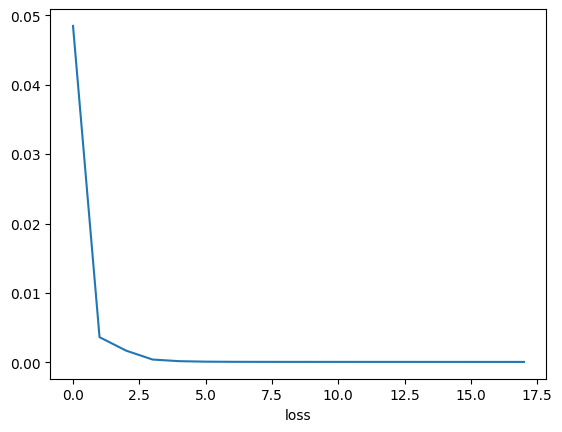

Coefficient of determination (r2 score): 1.0000


In [6]:
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.xlabel('loss')
plt.show()

#applying the the model on the test data (features)
prediction = mlp.predict(input_test)

#coefficient of determination (r2 score): 1 is perfect prediction (it can get arbitrary negative)
print('Coefficient of determination (r2 score): %.4f'% sklearn.metrics.r2_score(output_test, prediction))

### 4. Using the regressor recursively feeding back the output in the input pipeline one sample at a time

In [7]:
#size of the generated signal in samples
out_sig_size = 100000

#starting with a sample pipeline full of noise
inout_pipeline = np.random.random_sample(regression_size_smp)

#empty array for the output signal
sig_out = np.zeros(out_sig_size)

#loop generating signal offline
i = 0
while (i < out_sig_size):
    temp = mlp.predict(inout_pipeline.reshape(1,-1))
    sig_out[i] = temp
    inout_pipeline = np.append(inout_pipeline,temp)#latest output one at the end
    inout_pipeline = np.delete(inout_pipeline,0)#removing the oldest from the front
    i += 1



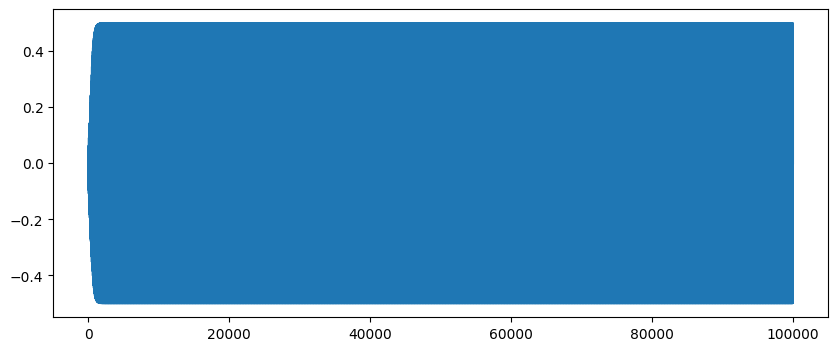

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(sig_out[0:100000])
plt.show()

Ipd.Audio(sig_out.flatten(), rate=sr)

### 5. Experimenting with manual alteration of the sample pipeline

In [9]:
#size of the generated signal in samples
out_sig_size = 100000

#starting with a sample pipeline full of noise
inout_pipeline = np.random.random_sample(regression_size_smp)

#empty array for the output signal
sig_out = np.zeros(out_sig_size)

#loop generating signal offline
i = 0
while (i < out_sig_size):
    temp = mlp.predict(inout_pipeline.reshape(1,-1))
    sig_out[i] = temp
    if np.random.random_sample(1) > 0.85: #once in a we alter randomly the signal that coes back in the pipeline
        temp = (np.random.random_sample(1)*2) -1
    inout_pipeline = np.append(inout_pipeline,temp)#latest output one at the end
    inout_pipeline = np.delete(inout_pipeline,0)#removing the oldest from the front
    i += 1

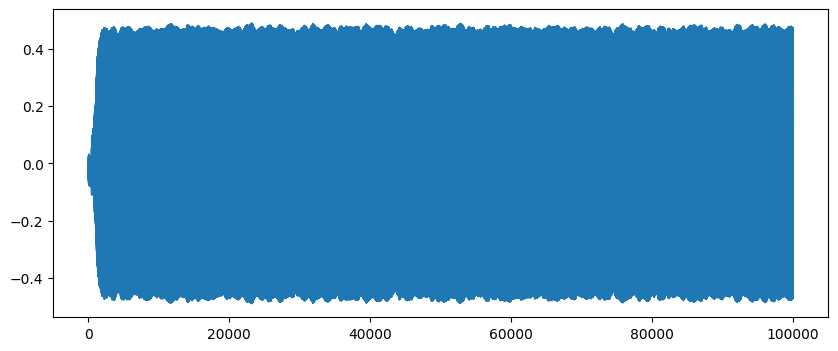

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(sig_out)
plt.show()

Ipd.Audio(sig_out.flatten(), rate=sr)

### 6. Follow-up Activities

1. Observe the impact of 'recursion_smp' on the prediction accuracy, and explore if this depends also on the frequency of the sine tone
2. Attempt raw audio generation of a more complex signal, either loading an audio file, or by summing more sinusoidal tones at different frequencies.
3. Attempt to generate two different signals (for example, sine tones at different frequencies), and include an extra parameter to 'condition' the network prediction (e.g. the value of the sine frequency, or 1 for frequency X and 0 for frequency Y).
4. Turn this example into a sequence classifier and check out whether the MLP classifier can identify sine signals at different frequencies (use the frequency as label or just an integer). Check out the impact on the sequence length on the prediction accuracy.
5. Use the same approach to predict a sequence of notes of a monoponic sequence/melody (e.g. feed the nerwork with a sequence of Pitch-Duration values (flattened), or attempt with pitch only first.